# **Load Dataset**

In [ ]:
from google.colab import files
uploaded=files.upload()
print(uploaded)

Saving Dataset.csv to Dataset.csv
{'Dataset.csv': b'DATE,TIME,VOLTAGE,CURRENT,PF,POWER (KW),"""WEEKEND/WEEKDAY""",SEASON,Temp (F),Humidity (%),Substation Shutdown,F1,F2,F3,F4,Jul-Oct-,Rainy,0\n01/01/2021,01-00,11.6,102,0.96,1967.38801489488,0,1,65,90,,,,,,Nov-Feb,Winter,1\n,02-00,11.6,102,0.96,1967.38801489488,0,1,65,90,,,,,,Mar-Jun,Summer,2\n,03-00,11.6,102,0.96,1967.38801489488,0,1,65,90,,,,,,,,\n,04-00,11.3,130,0.96,2442.60733086593,0,1,78,49,,,,,,Weekend,1,\n,05-00,11.2,148,0.96,2756.20552188112,0,1,78,49,,,,,,Weekday,0,\n,06-00,11.2,172,0.96,3203.15776867266,0,1,78,49,,,,,,Missing Values,66,\n,07-00,11.5,218,0.96,4168.56131959217,0,1,83,34,,,,,,,,\n,08-00,11.2,274,0.96,5102.70481753668,0,1,83,34,,,,,,,,\n,09-00,11.2,280,0.96,5214.44287923456,0,1,83,34,,,,,,,,\n,10-00,11.5,254,0.96,4856.94759255234,0,1,81,42,,,,,,,,\n,11-00,11.5,254,0.96,4856.94759255234,0,1,81,42,,,,,,,,\n,12-00,11.5,243,0.96,4646.60734248118,0,1,81,42,,,,,,,,\n,13-00,11.6,231,0.96,4455.5552102031,0,1,71,42,,,,,,,

# **Data Cleaning**

INITIAL DATASET OVERVIEW
Shape: (8760, 18)
Columns: ['DATE', 'TIME', 'VOLTAGE', 'CURRENT', 'PF', 'POWER (KW)', '"WEEKEND/WEEKDAY"', 'SEASON', 'Temp (F)', 'Humidity (%)', 'Substation Shutdown', 'F1', 'F2', 'F3', 'F4', 'Jul-Oct-', 'Rainy', '0']

         DATE   TIME  VOLTAGE  CURRENT    PF   POWER (KW)  "WEEKEND/WEEKDAY"  \
0  01/01/2021  01-00     11.6      102  0.96  1967.388015                  0   
1         NaN  02-00     11.6      102  0.96  1967.388015                  0   
2         NaN  03-00     11.6      102  0.96  1967.388015                  0   
3         NaN  04-00     11.3      130  0.96  2442.607331                  0   
4         NaN  05-00     11.2      148  0.96  2756.205522                  0   

   SEASON  Temp (F)  Humidity (%)  Substation Shutdown  F1  F2  F3  F4  \
0       1        65            90                  NaN NaN NaN NaN NaN   
1       1        65            90                  NaN NaN NaN NaN NaN   
2       1        65            90                  Na

/tmp/ipython-input-4165284249.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['DATE'] = df['DATE'].fillna(method='ffill')



Visualization saved to: data_quality_report.png


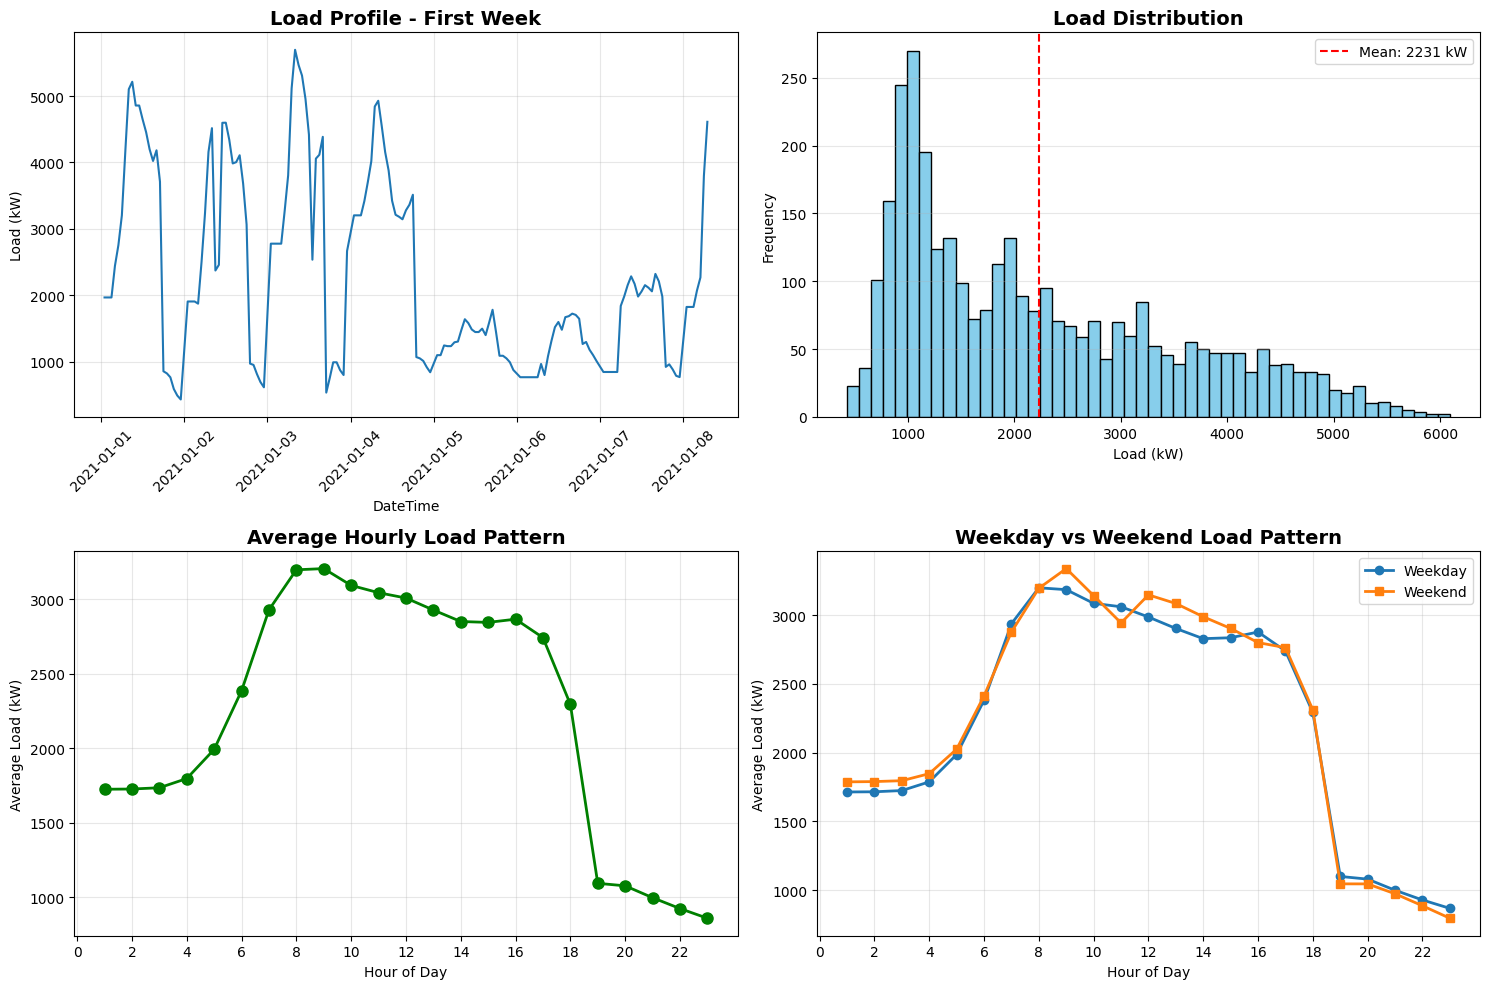


DATA CLEANING COMPLETED SUCCESSFULLY!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Load and display initial info
df = pd.read_csv('Dataset.csv')
print("="*60)
print("INITIAL DATASET OVERVIEW")
print("="*60)
print(f"Shape: {df.shape}\nColumns: {df.columns.tolist()}\n\n{df.head()}")

# ============================================
# DATA CLEANING PIPELINE
# ============================================
print("\n" + "="*60)
print("CLEANING DATA...")
print("="*60)

# Step 1-3: Fix date, select columns, and rename
df['DATE'] = df['DATE'].fillna(method='ffill')
columns_to_keep = ['DATE', 'TIME', 'VOLTAGE', 'CURRENT', 'PF', 'POWER (KW)',
                   '"WEEKEND/WEEKDAY"', 'SEASON', 'Temp (F)', 'Humidity (%)']
df_clean = df[columns_to_keep].copy()

df_clean.rename(columns={
    'DATE': 'date', 'TIME': 'time', 'VOLTAGE': 'voltage', 'CURRENT': 'current',
    'PF': 'power_factor', 'POWER (KW)': 'load_kw', '"WEEKEND/WEEKDAY"': 'is_weekend',
    'SEASON': 'season', 'Temp (F)': 'temperature_f', 'Humidity (%)': 'humidity'
}, inplace=True)

# Step 4: Create datetime index
df_clean['time'] = df_clean['time'].str.replace('-', ':')
df_clean['datetime'] = pd.to_datetime(df_clean['date'] + ' ' + df_clean['time'],
                                       format='%d/%m/%Y %H:%M', errors='coerce')
df_clean = df_clean[df_clean['datetime'].notna()]
df_clean.set_index('datetime', inplace=True)
df_clean.sort_index(inplace=True)
df_clean.drop(['date', 'time'], axis=1, inplace=True)

print(f"Datetime range: {df_clean.index.min()} to {df_clean.index.max()}")

# Step 5: Handle missing values
print(f"\nMissing values before: {df_clean.isnull().sum().sum()}")

# Interpolate numerical columns
num_cols = ['load_kw', 'voltage', 'current', 'power_factor', 'temperature_f', 'humidity']
for col in num_cols:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col] = df_clean[col].interpolate(method='time', limit_direction='both')
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

# Handle categorical features
df_clean['is_weekend'] = df_clean.get('is_weekend', (df_clean.index.dayofweek >= 5).astype(int))
df_clean['is_weekend'] = df_clean['is_weekend'].fillna(0).astype(int)
df_clean.loc[df_clean['is_weekend'] != 0, 'is_weekend'] = 1

if 'season' not in df_clean.columns or df_clean['season'].isnull().sum() > 0:
    month = df_clean.index.month
    df_clean['season'] = pd.cut(month, bins=[0, 2, 5, 8, 11, 12],
                                 labels=[1, 2, 3, 4, 1], include_lowest=True).astype(int)

print(f"Missing values after: {df_clean.isnull().sum().sum()}")

# Step 6: Handle outliers using IQR method
Q1, Q3 = df_clean['load_kw'].quantile([0.25, 0.75])
IQR = Q3 - Q1
outliers = (df_clean['load_kw'] < Q1 - 2*IQR) | (df_clean['load_kw'] > Q3 + 2*IQR)
print(f"\nOutliers detected: {outliers.sum()}")
if outliers.sum() > 0:
    df_clean.loc[outliers, 'load_kw'] = np.nan
    df_clean['load_kw'] = df_clean['load_kw'].interpolate(method='time')

# Step 7: Ensure correct data types
for col in num_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Step 8: Add time-based features
df_clean['hour'] = df_clean.index.hour
df_clean['day_of_week'] = df_clean.index.dayofweek
df_clean['day_of_month'] = df_clean.index.day
df_clean['month'] = df_clean.index.month
df_clean['day_of_year'] = df_clean.index.dayofyear

# Cyclical encodings
df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24)
df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24)
df_clean['dow_sin'] = np.sin(2 * np.pi * df_clean['day_of_week'] / 7)
df_clean['dow_cos'] = np.cos(2 * np.pi * df_clean['day_of_week'] / 7)

# ============================================
# SUMMARY & SAVE
# ============================================
print("\n" + "="*60)
print("FINAL CLEANED DATASET SUMMARY")
print("="*60)
print(f"Shape: {df_clean.shape}\nColumns: {df_clean.columns.tolist()}")
print(f"\nLoad Stats - Min: {df_clean['load_kw'].min():.2f}, Max: {df_clean['load_kw'].max():.2f}, "
      f"Mean: {df_clean['load_kw'].mean():.2f}, Std: {df_clean['load_kw'].std():.2f} kW")

df_clean.to_csv('cleaned_electric_load_data.csv')
print("\nSaved to: cleaned_electric_load_data.csv")

# ============================================
# VISUALIZATION
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: First week load profile
axes[0, 0].plot(df_clean.index[:168], df_clean['load_kw'][:168], linewidth=1.5)
axes[0, 0].set_title('Load Profile - First Week', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('DateTime')
axes[0, 0].set_ylabel('Load (kW)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Load distribution
axes[0, 1].hist(df_clean['load_kw'], bins=50, edgecolor='black', color='skyblue')
axes[0, 1].axvline(df_clean['load_kw'].mean(), color='red', linestyle='--',
                   label=f'Mean: {df_clean["load_kw"].mean():.0f} kW')
axes[0, 1].set_title('Load Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Load (kW)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].legend()

# Plot 3: Hourly average pattern
hourly_avg = df_clean.groupby('hour')['load_kw'].mean()
axes[1, 0].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2,
                markersize=8, color='green')
axes[1, 0].set_title('Average Hourly Load Pattern', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Average Load (kW)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(range(0, 24, 2))

# Plot 4: Weekend vs Weekday
try:
    weekend_avg = df_clean.groupby(['hour', 'is_weekend'])['load_kw'].mean().unstack()
    if 0 in weekend_avg.columns and 1 in weekend_avg.columns:
        axes[1, 1].plot(weekend_avg.index, weekend_avg[0], label='Weekday',
                       marker='o', linewidth=2, markersize=6)
        axes[1, 1].plot(weekend_avg.index, weekend_avg[1], label='Weekend',
                       marker='s', linewidth=2, markersize=6)
    axes[1, 1].set_title('Weekday vs Weekend Load Pattern', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Hour of Day')
    axes[1, 1].set_ylabel('Average Load (kW)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xticks(range(0, 24, 2))
except:
    axes[1, 1].text(0.5, 0.5, 'Weekend comparison\nerror',
                    ha='center', va='center', transform=axes[1, 1].transAxes)

plt.tight_layout()
plt.savefig('data_quality_report.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved to: data_quality_report.png")
plt.show()

print("\n" + "="*60)
print("DATA CLEANING COMPLETED SUCCESSFULLY!")
print("="*60)

# **Feature Engineering**

DATA PREPARATION PIPELINE

1. Creating lag and rolling features...

2. Creating temporal features...

3. Creating weather interaction features...

4. Removing NaN rows: 3312 → 3144 rows

FEATURE SELECTION
Total features: 22

TIME-SERIES DATA SPLITTING
Train: 2200 (70.0%) | 2021-01-08 08:00:00 to 2021-09-07 22:00:00
Val:   471 (15.0%) | 2021-09-07 23:00:00 to 2021-11-04 10:00:00
Test:  473 (15.0%) | 2021-11-04 11:00:00 to 2021-12-12 23:00:00

FEATURE SCALING

1. MinMax scaling (0-1) for ANFIS...
2. Standard scaling (mean=0, std=1) for MLP...

SAVING PREPARED DATA
✓ Saved CSV files
✓ Saved MinMax arrays
✓ Saved Standard arrays
✓ Saved scaler objects
✓ Saved feature names

GENERATING VISUALIZATIONS
✓ Saved visualization


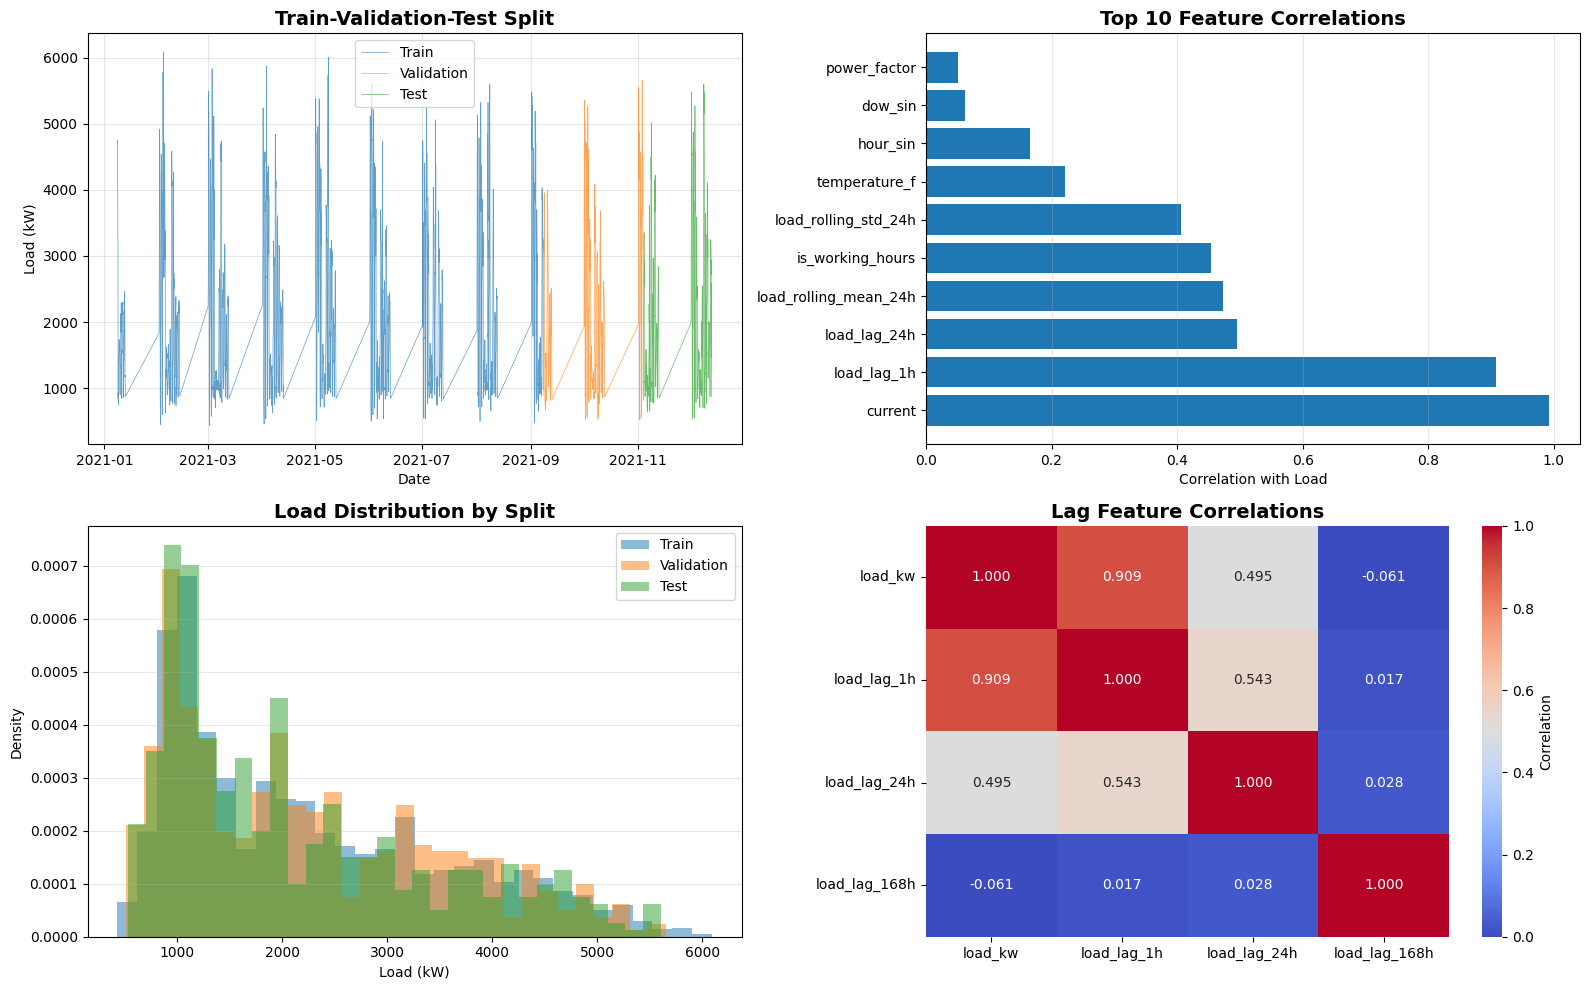


FINAL SUMMARY

   Dataset  Samples Percentage  Load Mean (kW)  Load Std (kW)
     Train     2200      70.0%     2253.651176    1291.437783
Validation      471      15.0%     2227.319261    1251.999085
      Test      473      15.0%     2106.829519    1261.950025
     Total     3144     100.0%     2227.617787    1281.839658

DATA PREPARATION COMPLETE!

Next Steps:
  1. ARIMA: Use train_data.csv (load_kw column)
  2. MLP: Use X_train_standard.npy arrays
  3. ANFIS: Use X_train_minmax.npy arrays


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle

# Load cleaned dataset
df = pd.read_csv('cleaned_electric_load_data.csv', index_col='datetime', parse_dates=True)

print("="*70)
print("DATA PREPARATION PIPELINE")
print("="*70)

# ============================================
# STEP 1: FEATURE ENGINEERING
# ============================================
print("\n1. Creating lag and rolling features...")
# Lag features
df['load_lag_1h'] = df['load_kw'].shift(1)
df['load_lag_24h'] = df['load_kw'].shift(24)
df['load_lag_168h'] = df['load_kw'].shift(168)

# Rolling features
for window in [3, 6, 24]:
    df[f'load_rolling_mean_{window}h'] = df['load_kw'].rolling(window=window, min_periods=1).mean()
df['load_rolling_std_24h'] = df['load_kw'].rolling(window=24, min_periods=1).std()

print("\n2. Creating temporal features...")
# Peak and working hours
df['is_peak_morning'] = df['hour'].isin([7, 8, 9]).astype(int)
df['is_peak_evening'] = df['hour'].isin([18, 19, 20, 21]).astype(int)
df['is_peak_hour'] = (df['is_peak_morning'] | df['is_peak_evening']).astype(int)
df['is_night'] = df['hour'].isin(range(6)).astype(int)
df['is_working_hours'] = df['hour'].isin(range(9, 18)).astype(int)
df['weekend_hour'] = df['is_weekend'] * df['hour']

print("\n3. Creating weather interaction features...")
# Weather interactions
df['temp_humidity_index'] = df['temperature_f'] * (df['humidity'] / 100)
df['temp_deviation'] = df['temperature_f'] - df['temperature_f'].mean()
df['season_temp'] = df['season'] * df['temperature_f']

# Remove NaN rows from lag features
print(f"\n4. Removing NaN rows: {len(df)} → ", end='')
df = df.dropna()
print(f"{len(df)} rows")

# ============================================
# STEP 2: FEATURE SELECTION
# ============================================
print("\n" + "="*70)
print("FEATURE SELECTION")
print("="*70)

ml_features = [
    'load_lag_1h', 'load_lag_24h', 'load_lag_168h',
    'load_rolling_mean_24h', 'load_rolling_std_24h',
    'hour', 'day_of_week', 'month', 'is_weekend',
    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',
    'is_peak_hour', 'is_working_hours',
    'temperature_f', 'humidity', 'temp_humidity_index',
    'voltage', 'current', 'power_factor', 'season'
]
ml_features = [f for f in ml_features if f in df.columns]
print(f"Total features: {len(ml_features)}")

# ============================================
# STEP 3: DATA SPLITTING (70-15-15)
# ============================================
print("\n" + "="*70)
print("TIME-SERIES DATA SPLITTING")
print("="*70)

total_rows = len(df)
train_size = int(0.70 * total_rows)
val_size = int(0.15 * total_rows)

train_data = df.iloc[:train_size].copy()
val_data = df.iloc[train_size:train_size + val_size].copy()
test_data = df.iloc[train_size + val_size:].copy()

print(f"Train: {len(train_data)} ({len(train_data)/total_rows*100:.1f}%) | "
      f"{train_data.index.min()} to {train_data.index.max()}")
print(f"Val:   {len(val_data)} ({len(val_data)/total_rows*100:.1f}%) | "
      f"{val_data.index.min()} to {val_data.index.max()}")
print(f"Test:  {len(test_data)} ({len(test_data)/total_rows*100:.1f}%) | "
      f"{test_data.index.min()} to {test_data.index.max()}")

# ============================================
# STEP 4: FEATURE SCALING
# ============================================
print("\n" + "="*70)
print("FEATURE SCALING")
print("="*70)

# Prepare X and y
X_train, y_train = train_data[ml_features].values, train_data['load_kw'].values
X_val, y_val = val_data[ml_features].values, val_data['load_kw'].values
X_test, y_test = test_data[ml_features].values, test_data['load_kw'].values

# MinMax Scaling (for ANFIS)
print("\n1. MinMax scaling (0-1) for ANFIS...")
minmax_scaler = MinMaxScaler()
X_train_minmax = minmax_scaler.fit_transform(X_train)
X_val_minmax = minmax_scaler.transform(X_val)
X_test_minmax = minmax_scaler.transform(X_test)

y_scaler_minmax = MinMaxScaler()
y_train_minmax = y_scaler_minmax.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_minmax = y_scaler_minmax.transform(y_val.reshape(-1, 1)).flatten()
y_test_minmax = y_scaler_minmax.transform(y_test.reshape(-1, 1)).flatten()

# Standard Scaling (for MLP)
print("2. Standard scaling (mean=0, std=1) for MLP...")
standard_scaler = StandardScaler()
X_train_standard = standard_scaler.fit_transform(X_train)
X_val_standard = standard_scaler.transform(X_val)
X_test_standard = standard_scaler.transform(X_test)

y_scaler_standard = StandardScaler()
y_train_standard = y_scaler_standard.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_standard = y_scaler_standard.transform(y_val.reshape(-1, 1)).flatten()
y_test_standard = y_scaler_standard.transform(y_test.reshape(-1, 1)).flatten()

# ============================================
# STEP 5: SAVE ALL DATA
# ============================================
print("\n" + "="*70)
print("SAVING PREPARED DATA")
print("="*70)

# Save DataFrames
for name, data in [('train', train_data), ('val', val_data), ('test', test_data)]:
    data.to_csv(f'{name}_data.csv')
print("✓ Saved CSV files")

# Save MinMax arrays
for name, arr in [('X_train', X_train_minmax), ('X_val', X_val_minmax), ('X_test', X_test_minmax),
                  ('y_train', y_train_minmax), ('y_val', y_val_minmax), ('y_test', y_test_minmax)]:
    np.save(f'{name}_minmax.npy', arr)
print("✓ Saved MinMax arrays")

# Save Standard arrays
for name, arr in [('X_train', X_train_standard), ('X_val', X_val_standard), ('X_test', X_test_standard),
                  ('y_train', y_train_standard), ('y_val', y_val_standard), ('y_test', y_test_standard)]:
    np.save(f'{name}_standard.npy', arr)
print("✓ Saved Standard arrays")

# Save scalers
for name, obj in [('minmax_scaler', minmax_scaler), ('y_scaler_minmax', y_scaler_minmax),
                  ('standard_scaler', standard_scaler), ('y_scaler_standard', y_scaler_standard)]:
    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(obj, f)
print("✓ Saved scaler objects")

# Save feature names
with open('feature_names.txt', 'w') as f:
    f.write('\n'.join(ml_features))
print("✓ Saved feature names")

# ============================================
# STEP 6: VISUALIZATION
# ============================================
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Train-Val-Test Split
axes[0, 0].plot(train_data.index, train_data['load_kw'], label='Train', alpha=0.7, linewidth=0.5)
axes[0, 0].plot(val_data.index, val_data['load_kw'], label='Validation', alpha=0.7, linewidth=0.5)
axes[0, 0].plot(test_data.index, test_data['load_kw'], label='Test', alpha=0.7, linewidth=0.5)
axes[0, 0].set_title('Train-Validation-Test Split', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Load (kW)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Top Feature Correlations
correlations = train_data[ml_features + ['load_kw']].corr()['load_kw'].drop('load_kw').sort_values(ascending=False)
top_features = correlations.head(10)
axes[0, 1].barh(range(len(top_features)), top_features.values)
axes[0, 1].set_yticks(range(len(top_features)))
axes[0, 1].set_yticklabels(top_features.index)
axes[0, 1].set_xlabel('Correlation with Load')
axes[0, 1].set_title('Top 10 Feature Correlations', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Plot 3: Load Distribution by Split
axes[1, 0].hist(train_data['load_kw'], bins=30, alpha=0.5, label='Train', density=True)
axes[1, 0].hist(val_data['load_kw'], bins=30, alpha=0.5, label='Validation', density=True)
axes[1, 0].hist(test_data['load_kw'], bins=30, alpha=0.5, label='Test', density=True)
axes[1, 0].set_xlabel('Load (kW)')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Load Distribution by Split', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Lag Feature Correlations
lag_cols = ['load_kw', 'load_lag_1h', 'load_lag_24h', 'load_lag_168h']
lag_corr = train_data[lag_cols].corr()
sns.heatmap(lag_corr, annot=True, fmt='.3f', cmap='coolwarm', ax=axes[1, 1],
            vmin=0, vmax=1, cbar_kws={'label': 'Correlation'})
axes[1, 1].set_title('Lag Feature Correlations', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('data_preparation_report.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization")
plt.show()

# ============================================
# SUMMARY
# ============================================
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

summary = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test', 'Total'],
    'Samples': [len(train_data), len(val_data), len(test_data), len(df)],
    'Percentage': [f"{len(train_data)/len(df)*100:.1f}%", f"{len(val_data)/len(df)*100:.1f}%",
                   f"{len(test_data)/len(df)*100:.1f}%", "100.0%"],
    'Load Mean (kW)': [train_data['load_kw'].mean(), val_data['load_kw'].mean(),
                       test_data['load_kw'].mean(), df['load_kw'].mean()],
    'Load Std (kW)': [train_data['load_kw'].std(), val_data['load_kw'].std(),
                      test_data['load_kw'].std(), df['load_kw'].std()]
})

print(f"\n{summary.to_string(index=False)}")

print("\n" + "="*70)
print("DATA PREPARATION COMPLETE!")
print("\nNext Steps:")
print("  1. ARIMA: Use train_data.csv (load_kw column)")
print("  2. MLP: Use X_train_standard.npy arrays")
print("  3. ANFIS: Use X_train_minmax.npy arrays")
print("="*70)

# **ARIMA Model**

ARIMA MODEL - SHORT-TERM LOAD FORECASTING

Loading data...
Train: 2200 | Validation: 471 | Test: 473

STATIONARITY CHECK (ADF Test)
ADF Statistic: -7.8761 | p-value: 0.0000
✓ STATIONARY (p-value <= 0.05)

GENERATING ACF & PACF PLOTS
✓ Saved: arima_acf_pacf.png

ARIMA MODEL SELECTION
Order (1, 0, 1): AIC=33888.19
Order (2, 0, 1): AIC=33814.07
Order (1, 0, 2): AIC=33869.72
Order (2, 0, 2): AIC=33815.88

✓ Best ARIMA order: (2, 0, 1) (AIC=33814.07)

TRAINING FINAL MODEL
✓ Model trained successfully

MAKING PREDICTIONS
✓ Hourly predictions completed
✓ Daily predictions completed

MODEL EVALUATION

--- HOURLY FORECASTING ---

Validation: RMSE=1255.53 kW | MAE=1064.61 kW | MAPE=68.56%

Test: RMSE=1264.58 kW | MAE=1074.16 kW | MAPE=71.74%

--- DAILY AVERAGE FORECASTING ---

Test: RMSE=772.80 kW | MAE=672.46 kW | MAPE=40.16%

SAVING RESULTS
✓ Saved: predictions, metrics, and model files

GENERATING VISUALIZATIONS
✓ Saved: arima_results.png


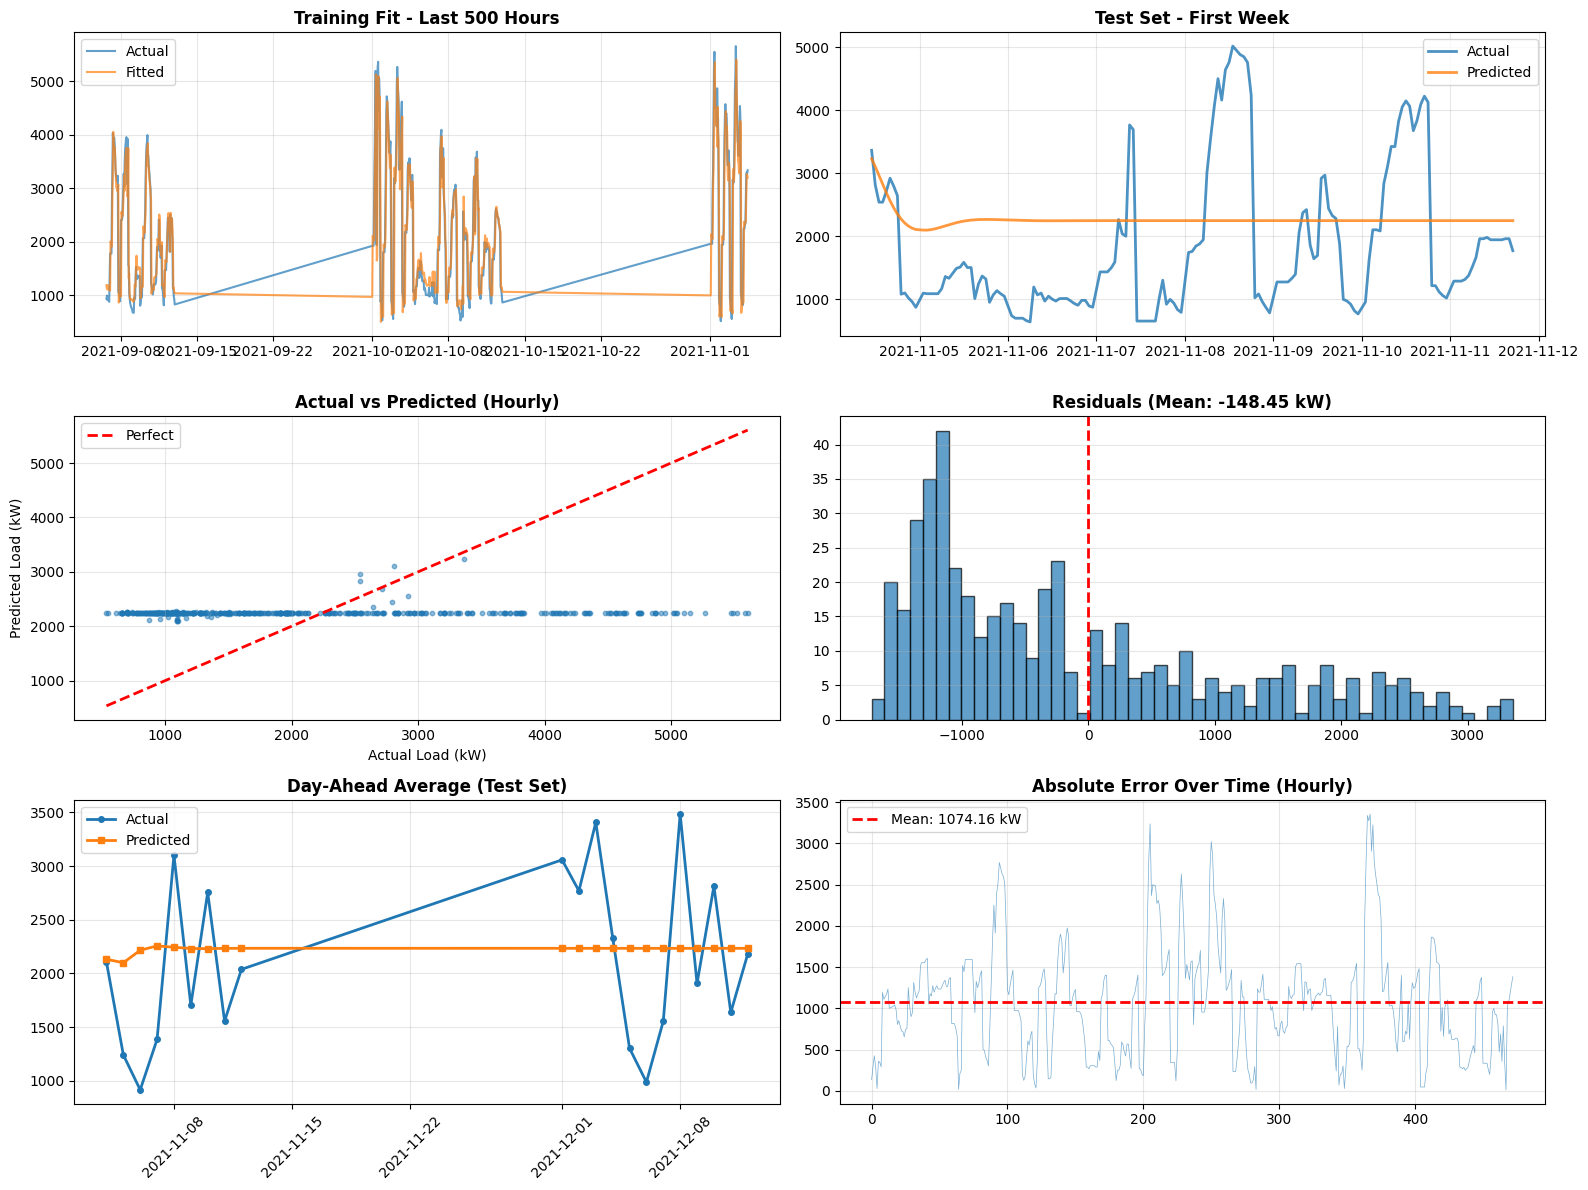


ARIMA MODEL SUMMARY
Best Model: ARIMA(2, 0, 1) | AIC: 33814.07

Hourly Test: RMSE=1264.58 kW | MAE=1074.16 kW | MAPE=71.74%
Daily Test: RMSE=772.80 kW | MAE=672.46 kW | MAPE=40.16%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("ARIMA MODEL - SHORT-TERM LOAD FORECASTING")
print("="*70)

# ============================================
# STEP 1: LOAD DATA
# ============================================
print("\nLoading data...")
train_data = pd.read_csv('train_data.csv', index_col='datetime', parse_dates=True)
val_data = pd.read_csv('val_data.csv', index_col='datetime', parse_dates=True)
test_data = pd.read_csv('test_data.csv', index_col='datetime', parse_dates=True)

train_load = train_data['load_kw']
val_load = val_data['load_kw']
test_load = test_data['load_kw']
train_val_load = pd.concat([train_load, val_load])

print(f"Train: {len(train_load)} | Validation: {len(val_load)} | Test: {len(test_load)}")

# ============================================
# STEP 2: STATIONARITY CHECK
# ============================================
print("\n" + "="*70)
print("STATIONARITY CHECK (ADF Test)")
print("="*70)

result = adfuller(train_load.dropna())
print(f'ADF Statistic: {result[0]:.4f} | p-value: {result[1]:.4f}')
print(f'{"✓ STATIONARY" if result[1] <= 0.05 else "✗ NON-STATIONARY"} (p-value {"<=" if result[1] <= 0.05 else ">"} 0.05)')

# ============================================
# STEP 3: ACF & PACF PLOTS
# ============================================
print("\n" + "="*70)
print("GENERATING ACF & PACF PLOTS")
print("="*70)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))
plot_acf(train_load.dropna(), lags=48, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

plot_pacf(train_load.dropna(), lags=48, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('arima_acf_pacf.png', dpi=300, bbox_inches='tight')
print("✓ Saved: arima_acf_pacf.png")
plt.close()

# ============================================
# STEP 4: MODEL SELECTION
# ============================================
print("\n" + "="*70)
print("ARIMA MODEL SELECTION")
print("="*70)

configs = [(1, 0, 1), (2, 0, 1), (1, 0, 2), (2, 0, 2)]
best_aic, best_order = np.inf, None

for order in configs:
    try:
        model = ARIMA(train_load, order=order).fit()
        print(f"Order {order}: AIC={model.aic:.2f}")
        if model.aic < best_aic:
            best_aic, best_order = model.aic, order
    except:
        print(f"Order {order}: Failed")

print(f"\n✓ Best ARIMA order: {best_order} (AIC={best_aic:.2f})")

# ============================================
# STEP 5: TRAIN FINAL MODEL
# ============================================
print("\n" + "="*70)
print("TRAINING FINAL MODEL")
print("="*70)

fitted_arima = ARIMA(train_val_load, order=best_order).fit()
print("✓ Model trained successfully")

# ============================================
# STEP 6: PREDICTIONS
# ============================================
print("\n" + "="*70)
print("MAKING PREDICTIONS")
print("="*70)

# Hourly predictions
val_pred = ARIMA(train_load, order=best_order).fit().forecast(steps=len(val_load))
test_pred = fitted_arima.forecast(steps=len(test_load))
print("✓ Hourly predictions completed")

# Daily predictions
train_daily, val_daily, test_daily = [x.resample('D').mean() for x in [train_load, val_load, test_load]]
train_val_daily = pd.concat([train_daily, val_daily])

fitted_daily = ARIMA(train_val_daily.dropna(), order=(2, 1, 1)).fit()
test_daily_pred = fitted_daily.forecast(steps=len(test_daily.dropna()))
test_daily_pred.index = test_daily.dropna().index
print("✓ Daily predictions completed")

# ============================================
# STEP 7: EVALUATION
# ============================================
print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

def calculate_metrics(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.nan_to_num(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, nan=0.0, posinf=100.0)
    print(f"\n{name}: RMSE={rmse:.2f} kW | MAE={mae:.2f} kW | MAPE={mape:.2f}%")
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

print("\n--- HOURLY FORECASTING ---")
val_metrics = calculate_metrics(val_load.values, val_pred.values, "Validation")
test_metrics = calculate_metrics(test_load.values, test_pred.values, "Test")

print("\n--- DAILY AVERAGE FORECASTING ---")
test_daily_actual = test_daily.dropna()
test_daily_metrics = calculate_metrics(test_daily_actual.values,
                                       test_daily_pred.loc[test_daily_actual.index].values, "Test")

# ============================================
# STEP 8: SAVE RESULTS
# ============================================
print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

# Save predictions
pd.DataFrame({'actual': test_load.values, 'predicted': test_pred.values},
             index=test_load.index).to_csv('arima_hourly_predictions.csv')
pd.DataFrame({'actual': test_daily_actual.values, 'predicted': test_daily_pred.loc[test_daily_actual.index].values},
             index=test_daily_actual.index).to_csv('arima_daily_predictions.csv')

# Save metrics
pd.DataFrame({
    'Metric': ['RMSE (kW)', 'MAE (kW)', 'MAPE (%)'],
    'Hourly_Val': [val_metrics['RMSE'], val_metrics['MAE'], val_metrics['MAPE']],
    'Hourly_Test': [test_metrics['RMSE'], test_metrics['MAE'], test_metrics['MAPE']],
    'Daily_Test': [test_daily_metrics['RMSE'], test_daily_metrics['MAE'], test_daily_metrics['MAPE']]
}).to_csv('arima_metrics.csv', index=False)

# Save model
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(fitted_arima, f)

print("✓ Saved: predictions, metrics, and model files")

# ============================================
# STEP 9: VISUALIZATION
# ============================================
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Plot 1: Training Fit
train_pred = fitted_arima.fittedvalues
if not isinstance(train_pred.index, pd.DatetimeIndex):
    train_pred.index = train_val_load.index
axes[0, 0].plot(train_val_load.index[-500:], train_val_load.values[-500:], label='Actual', alpha=0.7, linewidth=1.5)
axes[0, 0].plot(train_val_load.index[-500:], train_pred.values[-500:], label='Fitted', alpha=0.7, linewidth=1.5)
axes[0, 0].set_title('Training Fit - Last 500 Hours', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Test Predictions (First Week)
if len(test_load) >= 168:
    axes[0, 1].plot(test_load.index[:168], test_load.values[:168], label='Actual', alpha=0.8, linewidth=2)
    axes[0, 1].plot(test_load.index[:168], test_pred.values[:168], label='Predicted', alpha=0.8, linewidth=2)
    axes[0, 1].set_title('Test Set - First Week', fontsize=12, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Scatter Plot
results_df = pd.DataFrame({'actual': test_load.values, 'predicted': test_pred.values})
axes[1, 0].scatter(results_df['actual'], results_df['predicted'], alpha=0.5, s=10)
min_val, max_val = min(results_df['actual'].min(), results_df['predicted'].min()), max(results_df['actual'].max(), results_df['predicted'].max())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')
axes[1, 0].set_xlabel('Actual Load (kW)')
axes[1, 0].set_ylabel('Predicted Load (kW)')
axes[1, 0].set_title('Actual vs Predicted (Hourly)', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Residuals
residuals = results_df['actual'] - results_df['predicted']
axes[1, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title(f'Residuals (Mean: {residuals.mean():.2f} kW)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Plot 5: Day-Ahead Predictions
daily_results_df = pd.DataFrame({'actual': test_daily_actual.values,
                                 'predicted': test_daily_pred.loc[test_daily_actual.index].values},
                                index=test_daily_actual.index)
axes[2, 0].plot(daily_results_df.index, daily_results_df['actual'], label='Actual', marker='o', linewidth=2, markersize=4)
axes[2, 0].plot(daily_results_df.index, daily_results_df['predicted'], label='Predicted', marker='s', linewidth=2, markersize=4)
axes[2, 0].set_title('Day-Ahead Average (Test Set)', fontsize=12, fontweight='bold')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)
axes[2, 0].tick_params(axis='x', rotation=45)

# Plot 6: Error Over Time
axes[2, 1].plot(results_df.index, np.abs(residuals), alpha=0.6, linewidth=0.5)
axes[2, 1].axhline(np.abs(residuals).mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.abs(residuals).mean():.2f} kW')
axes[2, 1].set_title('Absolute Error Over Time (Hourly)', fontsize=12, fontweight='bold')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('arima_results.png', dpi=300, bbox_inches='tight')
print("✓ Saved: arima_results.png")
plt.show()

# ============================================
# SUMMARY
# ============================================
print("\n" + "="*70)
print("ARIMA MODEL SUMMARY")
print("="*70)
print(f"Best Model: ARIMA{best_order} | AIC: {best_aic:.2f}")
print(f"\nHourly Test: RMSE={test_metrics['RMSE']:.2f} kW | MAE={test_metrics['MAE']:.2f} kW | MAPE={test_metrics['MAPE']:.2f}%")
print(f"Daily Test: RMSE={test_daily_metrics['RMSE']:.2f} kW | MAE={test_daily_metrics['MAE']:.2f} kW | MAPE={test_daily_metrics['MAPE']:.2f}%")
print("="*70)

# **MLP Model**

MLP NEURAL NETWORK - SHORT-TERM LOAD FORECASTING

Loading prepared data...
✓ Train: 2200 samples, 22 features | Val: 471 | Test: 473

HYPERPARAMETER TUNING

[1/5] Testing: Small (64)...
  RMSE: 125.69 kW | MAE: 99.65 kW | MAPE: 5.76% | Iter: 130

[2/5] Testing: Medium (128, 64)...
  RMSE: 109.30 kW | MAE: 82.92 kW | MAPE: 4.82% | Iter: 79

[3/5] Testing: Large (256, 128)...
  RMSE: 96.20 kW | MAE: 76.91 kW | MAPE: 4.68% | Iter: 56

[4/5] Testing: Deep (128, 64, 32)...
  RMSE: 125.26 kW | MAE: 98.47 kW | MAPE: 5.97% | Iter: 77

[5/5] Testing: Medium + Low Reg...
  RMSE: 110.68 kW | MAE: 83.37 kW | MAPE: 4.86% | Iter: 66

✓ Best: Large (256, 128) (Val RMSE: 96.20 kW)

     Configuration       RMSE       MAE     MAPE  Iterations
        Small (64) 125.693404 99.653789 5.758797         130
  Medium (128, 64) 109.297587 82.920261 4.819070          79
  Large (256, 128)  96.200035 76.914668 4.681019          56
Deep (128, 64, 32) 125.256944 98.474932 5.965561          77
  Medium + Low Reg 1

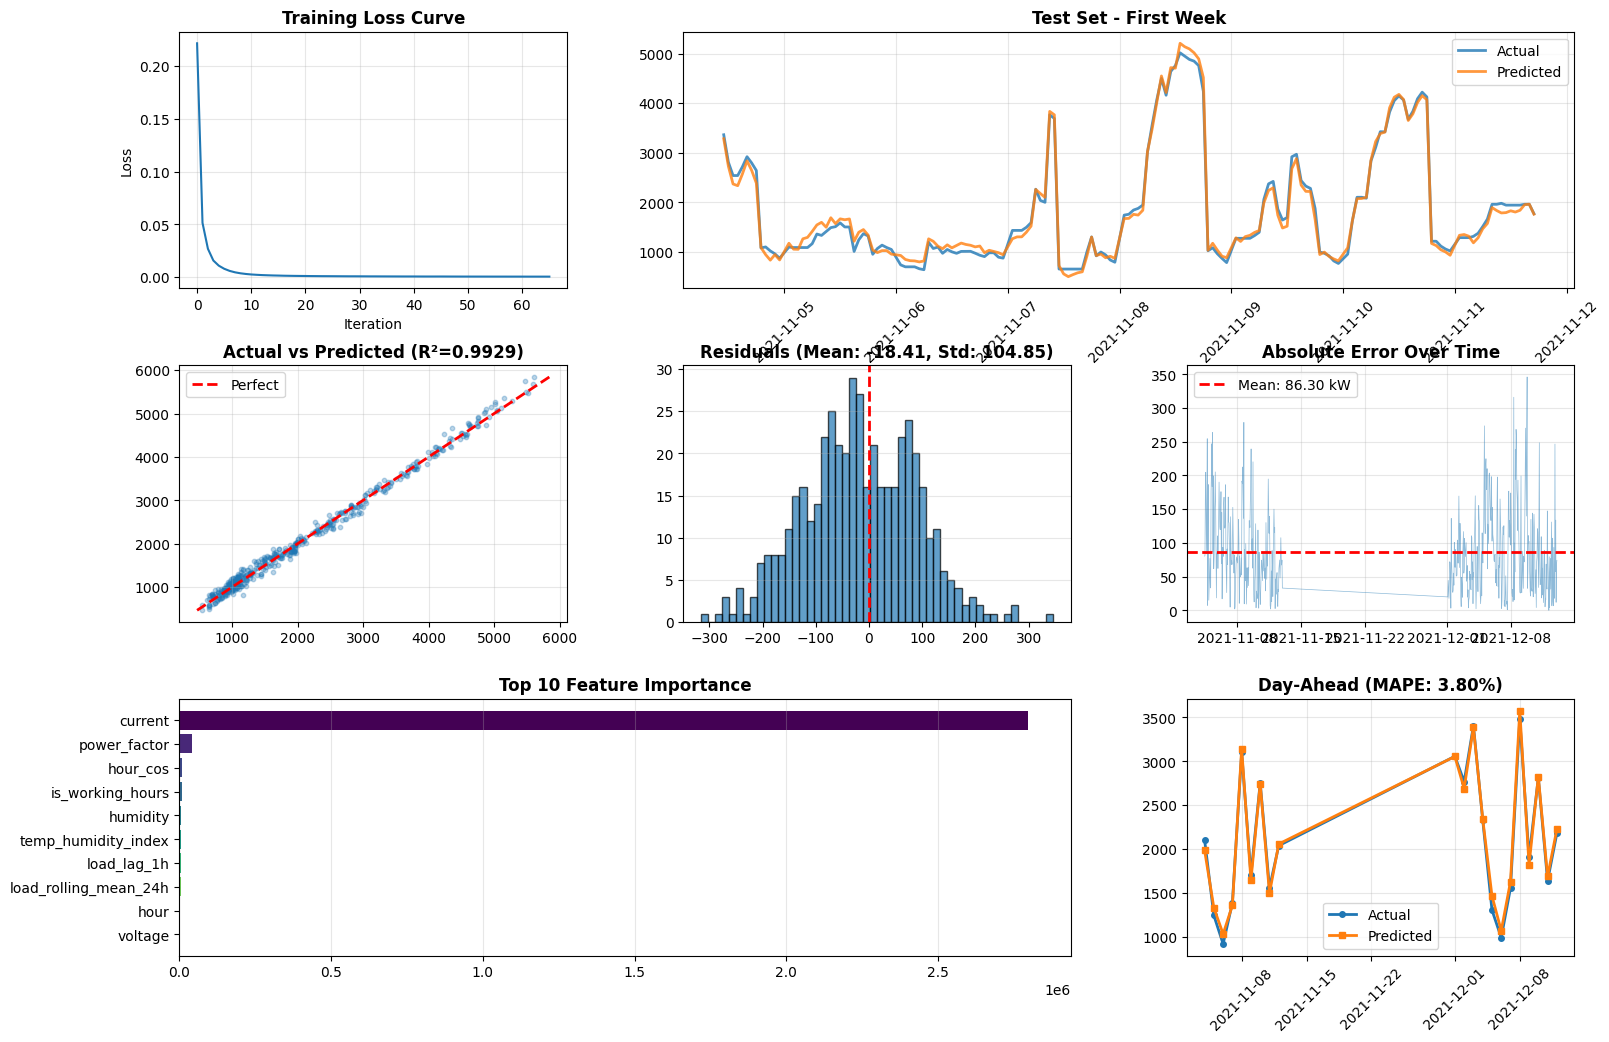


ERROR ANALYSIS

Error by Hour:
             mean        std         max
hour                                   
1     109.140848  79.663850  273.614241
2      67.792434  45.696135  148.930054
3      68.906759  43.153795  134.945740
4      74.934987  59.435695  215.251240
5      77.548520  58.387009  224.856975
6      88.645958  87.471694  316.005123
7      74.533128  56.359115  183.361418
8      84.026911  62.675577  263.831741
9      60.525286  42.131033  131.011620
10    106.126475  62.733066  238.246679
11     91.198284  57.834618  197.747433
12     92.019654  65.209379  268.361010
13    109.287124  88.813411  270.208598
14     97.181311  72.032007  208.500990
15     94.600561  64.363847  212.607895
16     94.363614  64.719584  266.962602
17     95.945309  78.874240  346.092383
18    112.436459  84.111079  278.816173
19     71.577195  50.416339  198.238247
20     87.874081  38.175803  168.830264
21     74.091698  40.401599  186.451483
22     76.586724  45.436810  174.056157
23     

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("MLP NEURAL NETWORK - SHORT-TERM LOAD FORECASTING")
print("="*70)

# ============================================
# STEP 1: LOAD DATA
# ============================================
print("\nLoading prepared data...")
X_train, y_train = np.load('X_train_standard.npy'), np.load('y_train_standard.npy')
X_val, y_val = np.load('X_val_standard.npy'), np.load('y_val_standard.npy')
X_test, y_test = np.load('X_test_standard.npy'), np.load('y_test_standard.npy')

with open('y_scaler_standard.pkl', 'rb') as f:
    y_scaler = pickle.load(f)
with open('feature_names.txt', 'r') as f:
    feature_names = [line.strip() for line in f.readlines()]

train_data = pd.read_csv('train_data.csv', index_col='datetime', parse_dates=True)
val_data = pd.read_csv('val_data.csv', index_col='datetime', parse_dates=True)
test_data = pd.read_csv('test_data.csv', index_col='datetime', parse_dates=True)

print(f"✓ Train: {X_train.shape[0]} samples, {X_train.shape[1]} features | Val: {X_val.shape[0]} | Test: {X_test.shape[0]}")

# ============================================
# STEP 2: HYPERPARAMETER TUNING
# ============================================
print("\n" + "="*70)
print("HYPERPARAMETER TUNING")
print("="*70)

configs = [
    {'hidden_layers': (64,), 'alpha': 0.001, 'name': 'Small (64)'},
    {'hidden_layers': (128, 64), 'alpha': 0.001, 'name': 'Medium (128, 64)'},
    {'hidden_layers': (256, 128), 'alpha': 0.001, 'name': 'Large (256, 128)'},
    {'hidden_layers': (128, 64, 32), 'alpha': 0.001, 'name': 'Deep (128, 64, 32)'},
    {'hidden_layers': (128, 64), 'alpha': 0.0001, 'name': 'Medium + Low Reg'},
]

best_val_rmse, best_config, results_list = np.inf, None, []

for i, config in enumerate(configs):
    print(f"\n[{i+1}/{len(configs)}] Testing: {config['name']}...")

    mlp = MLPRegressor(hidden_layer_sizes=config['hidden_layers'], activation='relu',
                       solver='adam', alpha=config['alpha'], learning_rate='adaptive',
                       max_iter=200, early_stopping=True, validation_fraction=0.1,
                       n_iter_no_change=20, random_state=42, verbose=False)
    mlp.fit(X_train, y_train)

    y_val_pred = y_scaler.inverse_transform(mlp.predict(X_val).reshape(-1, 1)).flatten()
    y_val_actual = y_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

    val_rmse = np.sqrt(mean_squared_error(y_val_actual, y_val_pred))
    val_mae = mean_absolute_error(y_val_actual, y_val_pred)
    val_mape = mean_absolute_percentage_error(y_val_actual, y_val_pred) * 100

    results_list.append({'Configuration': config['name'], 'RMSE': val_rmse,
                         'MAE': val_mae, 'MAPE': val_mape, 'Iterations': mlp.n_iter_})

    print(f"  RMSE: {val_rmse:.2f} kW | MAE: {val_mae:.2f} kW | MAPE: {val_mape:.2f}% | Iter: {mlp.n_iter_}")

    if val_rmse < best_val_rmse:
        best_val_rmse, best_config = val_rmse, config

print(f"\n✓ Best: {best_config['name']} (Val RMSE: {best_val_rmse:.2f} kW)")
print(f"\n{pd.DataFrame(results_list).to_string(index=False)}")

# ============================================
# STEP 3: TRAIN FINAL MODEL
# ============================================
print("\n" + "="*70)
print("TRAINING FINAL MODEL")
print("="*70)

final_mlp = MLPRegressor(hidden_layer_sizes=best_config['hidden_layers'], activation='relu',
                         solver='adam', alpha=best_config['alpha'], learning_rate='adaptive',
                         max_iter=500, early_stopping=True, validation_fraction=0.1,
                         n_iter_no_change=30, random_state=42, verbose=True)
final_mlp.fit(X_train, y_train)

print(f"\n✓ Completed in {final_mlp.n_iter_} iterations | Loss: {final_mlp.loss_:.6f}")

with open('mlp_model.pkl', 'wb') as f:
    pickle.dump(final_mlp, f)
print("✓ Model saved")

# ============================================
# STEP 4: PREDICTIONS & EVALUATION
# ============================================
print("\n" + "="*70)
print("PREDICTIONS & EVALUATION")
print("="*70)

def predict_and_inverse(X, y):
    y_pred = y_scaler.inverse_transform(final_mlp.predict(X).reshape(-1, 1)).flatten()
    y_actual = y_scaler.inverse_transform(y.reshape(-1, 1)).flatten()
    return y_actual, y_pred

y_train_actual, y_train_pred = predict_and_inverse(X_train, y_train)
y_val_actual, y_val_pred = predict_and_inverse(X_val, y_val)
y_test_actual, y_test_pred = predict_and_inverse(X_test, y_test)

def calculate_metrics(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))
    print(f"\n{name}: RMSE={rmse:.2f} kW | MAE={mae:.2f} kW | MAPE={mape:.2f}% | R²={r2:.4f}")
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

train_metrics = calculate_metrics(y_train_actual, y_train_pred, "Train")
val_metrics = calculate_metrics(y_val_actual, y_val_pred, "Validation")
test_metrics = calculate_metrics(y_test_actual, y_test_pred, "Test")

# ============================================
# STEP 5: FEATURE IMPORTANCE
# ============================================
print("\n" + "="*70)
print("FEATURE IMPORTANCE")
print("="*70)

baseline_score = mean_squared_error(y_val_actual, y_val_pred)
importances = []

for i in range(len(feature_names)):
    X_val_permuted = X_val.copy()
    np.random.shuffle(X_val_permuted[:, i])
    y_pred_permuted = y_scaler.inverse_transform(final_mlp.predict(X_val_permuted).reshape(-1, 1)).flatten()
    importances.append(mean_squared_error(y_val_actual, y_pred_permuted) - baseline_score)

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values('Importance', ascending=False)
print(f"\nTop 10 Features:\n{feature_importance_df.head(10).to_string(index=False)}")

# ============================================
# STEP 6: DAY-AHEAD PREDICTIONS
# ============================================
print("\n" + "="*70)
print("DAY-AHEAD PREDICTIONS")
print("="*70)

test_daily_actual = pd.Series(y_test_actual, index=test_data.index).resample('D').mean()
test_daily_pred = pd.Series(y_test_pred, index=test_data.index).resample('D').mean()
daily_comparison_df = pd.DataFrame({'actual': test_daily_actual, 'predicted': test_daily_pred}).dropna()

daily_rmse = np.sqrt(mean_squared_error(daily_comparison_df['actual'], daily_comparison_df['predicted']))
daily_mae = mean_absolute_error(daily_comparison_df['actual'], daily_comparison_df['predicted'])
daily_mape = mean_absolute_percentage_error(daily_comparison_df['actual'], daily_comparison_df['predicted']) * 100

print(f"Day-Ahead: RMSE={daily_rmse:.2f} kW | MAE={daily_mae:.2f} kW | MAPE={daily_mape:.2f}%")

# ============================================
# STEP 7: SAVE RESULTS
# ============================================
print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

residuals = y_test_actual - y_test_pred
pd.DataFrame({'actual': y_test_actual, 'predicted': y_test_pred, 'error': residuals,
              'abs_error': np.abs(residuals)}, index=test_data.index).to_csv('mlp_hourly_predictions.csv')
daily_comparison_df.to_csv('mlp_daily_predictions.csv')

pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test', 'Daily_Test'],
    'RMSE': [train_metrics['RMSE'], val_metrics['RMSE'], test_metrics['RMSE'], daily_rmse],
    'MAE': [train_metrics['MAE'], val_metrics['MAE'], test_metrics['MAE'], daily_mae],
    'MAPE': [train_metrics['MAPE'], val_metrics['MAPE'], test_metrics['MAPE'], daily_mape]
}).to_csv('mlp_metrics.csv', index=False)

feature_importance_df.to_csv('mlp_feature_importance.csv', index=False)
print("✓ Saved: predictions, metrics, and feature importance")

# ============================================
# STEP 8: VISUALIZATION
# ============================================
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Training Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(final_mlp.loss_curve_)
ax1.set_title('Training Loss Curve', fontweight='bold')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.grid(True, alpha=0.3)

# Plot 2: First Week Predictions
ax2 = fig.add_subplot(gs[0, 1:])
ax2.plot(test_data.index[:168], y_test_actual[:168], label='Actual', linewidth=2, alpha=0.8)
ax2.plot(test_data.index[:168], y_test_pred[:168], label='Predicted', linewidth=2, alpha=0.8)
ax2.set_title('Test Set - First Week', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Scatter Plot
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(y_test_actual, y_test_pred, alpha=0.3, s=10)
min_val, max_val = min(y_test_actual.min(), y_test_pred.min()), max(y_test_actual.max(), y_test_pred.max())
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')
ax3.set_title(f'Actual vs Predicted (R²={test_metrics["R2"]:.4f})', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Residuals
ax4 = fig.add_subplot(gs[1, 1])
ax4.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax4.axvline(0, color='red', linestyle='--', linewidth=2)
ax4.set_title(f'Residuals (Mean: {residuals.mean():.2f}, Std: {residuals.std():.2f})', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Error Over Time
ax5 = fig.add_subplot(gs[1, 2])
ax5.plot(test_data.index, np.abs(residuals), alpha=0.5, linewidth=0.5)
ax5.axhline(np.abs(residuals).mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {np.abs(residuals).mean():.2f} kW')
ax5.set_title('Absolute Error Over Time', fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Feature Importance
ax6 = fig.add_subplot(gs[2, :2])
top_10 = feature_importance_df.head(10)
ax6.barh(range(len(top_10)), top_10['Importance'], color=plt.cm.viridis(np.linspace(0, 1, len(top_10))))
ax6.set_yticks(range(len(top_10)))
ax6.set_yticklabels(top_10['Feature'])
ax6.set_title('Top 10 Feature Importance', fontweight='bold')
ax6.grid(True, alpha=0.3, axis='x')
ax6.invert_yaxis()

# Plot 7: Day-Ahead
ax7 = fig.add_subplot(gs[2, 2])
ax7.plot(daily_comparison_df.index, daily_comparison_df['actual'], marker='o', label='Actual', linewidth=2, markersize=4)
ax7.plot(daily_comparison_df.index, daily_comparison_df['predicted'], marker='s', label='Predicted', linewidth=2, markersize=4)
ax7.set_title(f'Day-Ahead (MAPE: {daily_mape:.2f}%)', fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3)
ax7.tick_params(axis='x', rotation=45)

plt.savefig('mlp_results.png', dpi=300, bbox_inches='tight')
print("✓ Saved: mlp_results.png")
plt.show()

# ============================================
# STEP 9: ERROR ANALYSIS
# ============================================
print("\n" + "="*70)
print("ERROR ANALYSIS")
print("="*70)

hourly_errors = pd.DataFrame({'hour': test_data.index.hour, 'error': np.abs(residuals)})
print("\nError by Hour:\n", hourly_errors.groupby('hour')['error'].agg(['mean', 'std', 'max']).to_string())

dow_errors = pd.DataFrame({'day': test_data.index.dayofweek, 'error': np.abs(residuals)})
dow_stats = dow_errors.groupby('day')['error'].agg(['mean', 'std'])
dow_stats.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
print("\nError by Day:\n", dow_stats.to_string())

print("\nError Percentiles:")
for p in [50, 75, 90, 95, 99]:
    print(f"  {p}th: {np.percentile(np.abs(residuals), p):.2f} kW")

# ============================================
# SUMMARY
# ============================================
print("\n" + "="*70)
print("MLP MODEL SUMMARY")
print("="*70)
print(f"Architecture: {best_config['hidden_layers']} | Iterations: {final_mlp.n_iter_}")
print(f"\nHourly Test: RMSE={test_metrics['RMSE']:.2f} kW | MAE={test_metrics['MAE']:.2f} kW | MAPE={test_metrics['MAPE']:.2f}% | R²={test_metrics['R2']:.4f}")
print(f"Daily Test: RMSE={daily_rmse:.2f} kW | MAE={daily_mae:.2f} kW | MAPE={daily_mape:.2f}%")
print(f"\nTop 3 Features:\n{feature_importance_df.head(3)[['Feature']].to_string(index=False)}")
print("="*70)

# **ANFIS Model**

ANFIS MODEL - ADVANCED SHORT-TERM LOAD FORECASTING

Loading data...
✓ Train: 2200, Val: 471, Test: 473 | Features: 22

FEATURE SELECTION

Selected top 8 features:
  1. current: 0.9922
  2. load_lag_1h: 0.9085
  3. hour_cos: 0.5668
  4. load_lag_24h: 0.4952
  5. load_rolling_mean_24h: 0.4738
  6. is_working_hours: 0.4539
  7. humidity: 0.4373
  8. temp_humidity_index: 0.4107

HYPERPARAMETER TUNING

[Testing] 2 MFs (Rules: 256)
  RMSE: 127.67 kW | MAE: 95.66 kW | MAPE: 5.11%

[Testing] 3 MFs (Rules: 6561)
  ⚠ Too many rules, skipping...

[Testing] 4 MFs (Rules: 65536)
  ⚠ Too many rules, skipping...

✓ Best: 2 MFs (RMSE: 127.67 kW)

 n_mfs  n_rules       RMSE       MAE     MAPE
     2      256 127.667029 95.655719 5.109926

TRAINING FINAL MODEL
Config: 8 inputs, 2 MFs, 256 rules
Epoch 10/150 - Train: 0.000591, Val: 0.000568
Epoch 20/150 - Train: 0.000614, Val: 0.000642
Epoch 30/150 - Train: 0.000553, Val: 0.000660

Early stopping at epoch 37

✓ Model saved

PREDICTIONS & EVALUATION

Trai

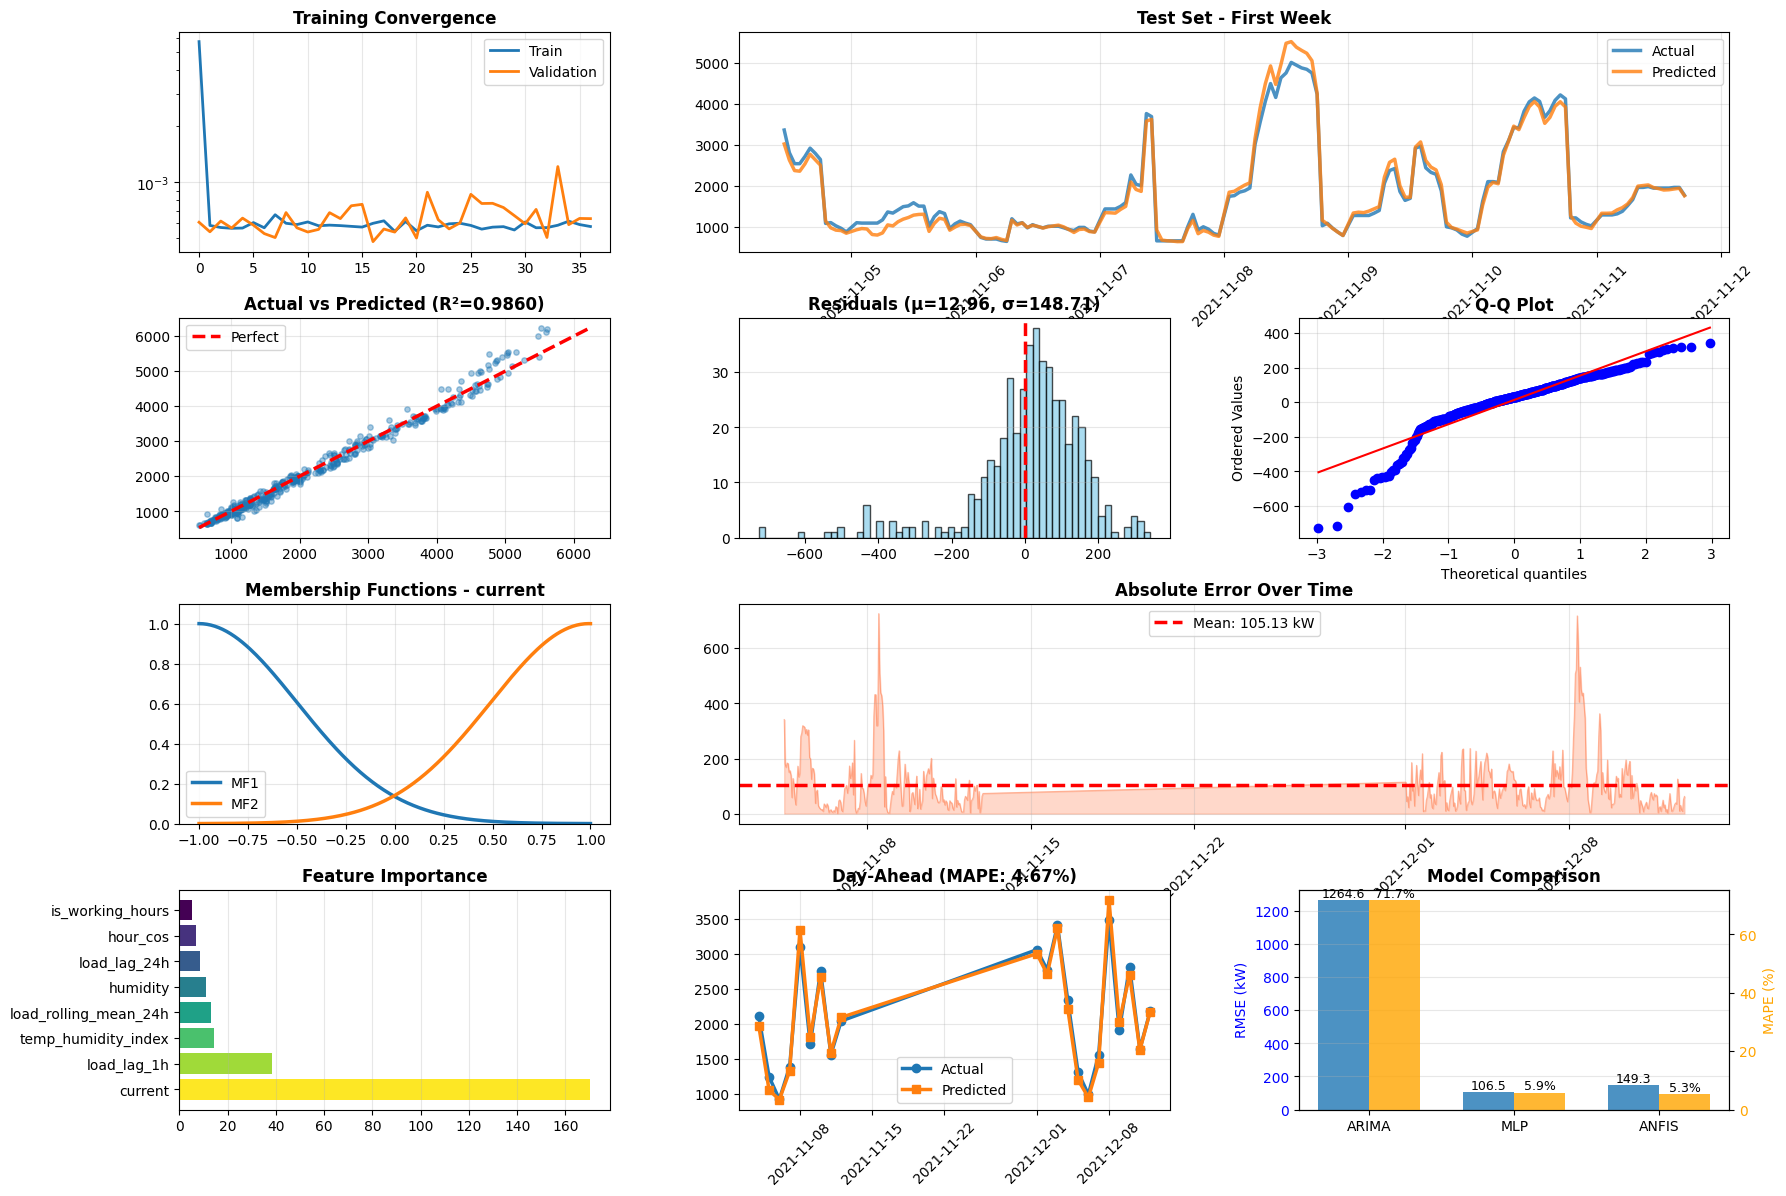


ERROR ANALYSIS

Error by Hour:
             mean         std         max
hour                                    
1      81.646890   56.626399  226.648069
2      67.454487   38.766001  133.398155
3      73.566524   41.787929  144.355921
4      75.722258   67.249453  279.587240
5      91.307669   79.286891  292.493999
6     108.031872   93.924191  356.439464
7     143.902571  129.352035  507.549396
8     148.115799  147.969434  521.938637
9     158.835450  172.545962  717.368624
10    141.284822  142.964155  607.899746
11    158.797334  115.767773  404.783835
12    158.695248  179.040968  725.555686
13    140.161539  129.941956  508.693962
14    136.739816  116.008046  438.063487
15    132.560223  116.627870  437.175198
16    128.803165  101.868453  392.404025
17    120.886086   83.182707  345.908622
18     92.556830   72.802853  230.472178
19     77.663371   51.413706  236.217011
20     50.643983   41.254800  128.968580
21     44.620916   32.874252  104.434985
22     44.758948   27.03

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy import stats
import pickle
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("ANFIS MODEL - ADVANCED SHORT-TERM LOAD FORECASTING")
print("="*70)

# ============================================
# ANFIS CLASS IMPLEMENTATION
# ============================================
class ANFIS:
    """Adaptive Neuro-Fuzzy Inference System with Gaussian MFs and TSK model"""

    def __init__(self, n_inputs, n_mfs=3, learning_rate=0.01):
        self.n_inputs = n_inputs
        self.n_mfs = n_mfs
        self.n_rules = n_mfs ** n_inputs
        self.learning_rate = learning_rate
        self.train_losses, self.val_losses = [], []
        self._initialize_parameters()

    def _initialize_parameters(self):
        self.premise_params = np.random.randn(self.n_inputs, self.n_mfs, 2) * 0.5
        for i in range(self.n_inputs):
            self.premise_params[i, :, 0] = np.linspace(-1, 1, self.n_mfs)
            self.premise_params[i, :, 1] = 0.5
        self.consequent_params = np.random.randn(self.n_rules, self.n_inputs + 1) * 0.1

    def _gaussian_mf(self, x, mean, std):
        return np.exp(-0.5 * ((x - mean) / (std + 1e-10)) ** 2)

    def _fuzzification(self, X):
        n_samples = X.shape[0]
        membership = np.zeros((n_samples, self.n_inputs, self.n_mfs))
        for i in range(self.n_inputs):
            for j in range(self.n_mfs):
                membership[:, i, j] = self._gaussian_mf(X[:, i], self.premise_params[i, j, 0],
                                                         np.abs(self.premise_params[i, j, 1]) + 1e-10)
        return membership

    def _rule_firing(self, membership):
        n_samples = membership.shape[0]
        firing_strengths = np.ones((n_samples, self.n_rules))
        rule_idx = 0
        for combo in np.ndindex(*[self.n_mfs] * self.n_inputs):
            rule_strength = np.ones(n_samples)
            for input_idx, mf_idx in enumerate(combo):
                rule_strength *= membership[:, input_idx, mf_idx]
            firing_strengths[:, rule_idx] = rule_strength
            rule_idx += 1
        return firing_strengths

    def _normalization(self, firing_strengths):
        return firing_strengths / (np.sum(firing_strengths, axis=1, keepdims=True) + 1e-10)

    def _consequent(self, X, normalized_strengths):
        X_bias = np.hstack([X, np.ones((X.shape[0], 1))])
        consequents = X_bias @ self.consequent_params.T
        return normalized_strengths * consequents

    def _defuzzification(self, weighted_consequents):
        return np.sum(weighted_consequents, axis=1)

    def forward(self, X):
        membership = self._fuzzification(X)
        firing_strengths = self._rule_firing(membership)
        normalized_strengths = self._normalization(firing_strengths)
        weighted_consequents = self._consequent(X, normalized_strengths)
        output = self._defuzzification(weighted_consequents)
        return output, {'membership': membership, 'firing_strengths': firing_strengths,
                       'normalized_strengths': normalized_strengths, 'weighted_consequents': weighted_consequents}

    def predict(self, X):
        output, _ = self.forward(X)
        return output

    def _compute_loss(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    def _update_consequent_params(self, X, y, normalized_strengths):
        X_bias = np.hstack([X, np.ones((X.shape[0], 1))])
        for i in range(self.n_rules):
            W = np.diag(normalized_strengths[:, i])
            try:
                XtWX = X_bias.T @ W @ X_bias + 1e-6 * np.eye(self.n_inputs + 1)
                self.consequent_params[i] = np.linalg.solve(XtWX, X_bias.T @ W @ y)
            except:
                error = y - normalized_strengths[:, i] * (X_bias @ self.consequent_params[i])
                gradient = -2 * X_bias.T @ (normalized_strengths[:, i] * error) / X.shape[0]
                self.consequent_params[i] -= self.learning_rate * gradient

    def _update_premise_params(self, X, y, membership, firing_strengths, normalized_strengths, output):
        error = output - y
        for i in range(self.n_inputs):
            for j in range(self.n_mfs):
                grad_mean, grad_std = 0, 0
                rule_idx = 0
                for combo in np.ndindex(*[self.n_mfs] * self.n_inputs):
                    if combo[i] == j:
                        X_bias = np.hstack([X, np.ones((X.shape[0], 1))])
                        rule_consequent = X_bias @ self.consequent_params[rule_idx]
                        mean, std = self.premise_params[i, j, 0], np.abs(self.premise_params[i, j, 1]) + 1e-10
                        dmf_dmean = membership[:, i, j] * (X[:, i] - mean) / (std ** 2)
                        dmf_dstd = membership[:, i, j] * ((X[:, i] - mean) ** 2) / (std ** 3)
                        dout_drule = rule_consequent * normalized_strengths[:, rule_idx]
                        grad_mean += np.sum(2 * error * dout_drule * dmf_dmean) / X.shape[0]
                        grad_std += np.sum(2 * error * dout_drule * dmf_dstd) / X.shape[0]
                    rule_idx += 1
                self.premise_params[i, j, 0] -= self.learning_rate * grad_mean
                self.premise_params[i, j, 1] -= self.learning_rate * grad_std * 0.1
                self.premise_params[i, j, 1] = np.abs(self.premise_params[i, j, 1])

    def fit(self, X_train, y_train, X_val=None, y_val=None, epochs=100, batch_size=32, verbose=True, patience=15):
        n_samples, n_batches = X_train.shape[0], X_train.shape[0] // batch_size
        best_val_loss, patience_counter = np.inf, 0

        for epoch in range(epochs):
            indices = np.random.permutation(n_samples)
            X_shuffled, y_shuffled = X_train[indices], y_train[indices]
            epoch_loss = 0

            for batch in range(n_batches):
                start_idx, end_idx = batch * batch_size, (batch + 1) * batch_size
                X_batch, y_batch = X_shuffled[start_idx:end_idx], y_shuffled[start_idx:end_idx]

                output, cache = self.forward(X_batch)
                epoch_loss += self._compute_loss(y_batch, output)

                self._update_consequent_params(X_batch, y_batch, cache['normalized_strengths'])
                self._update_premise_params(X_batch, y_batch, cache['membership'], cache['firing_strengths'],
                                           cache['normalized_strengths'], output)

            epoch_loss /= n_batches
            self.train_losses.append(epoch_loss)

            if X_val is not None and y_val is not None:
                val_loss = self._compute_loss(y_val, self.predict(X_val))
                self.val_losses.append(val_loss)

                if val_loss < best_val_loss:
                    best_val_loss, patience_counter = val_loss, 0
                    self.best_params = {'premise': self.premise_params.copy(), 'consequent': self.consequent_params.copy()}
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    if verbose:
                        print(f"\nEarly stopping at epoch {epoch+1}")
                    self.premise_params, self.consequent_params = self.best_params['premise'], self.best_params['consequent']
                    break

                if verbose and (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch+1}/{epochs} - Train: {epoch_loss:.6f}, Val: {val_loss:.6f}")
            elif verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Train: {epoch_loss:.6f}")

    def extract_rules(self, feature_names=None):
        if feature_names is None:
            feature_names = [f"Feature_{i}" for i in range(self.n_inputs)]
        linguistic_terms = ['LOW', 'MEDIUM', 'HIGH'] if self.n_mfs == 3 else (['VERY_LOW', 'LOW', 'MEDIUM', 'HIGH', 'VERY_HIGH'] if self.n_mfs == 5 else ['LOW', 'HIGH'])

        rules = []
        rule_idx = 0
        for combo in np.ndindex(*[self.n_mfs] * self.n_inputs):
            antecedent = [f"{feature_names[i]} is {linguistic_terms[mf_idx] if mf_idx < len(linguistic_terms) else f'MF{mf_idx}'}"
                         for i, mf_idx in enumerate(combo)]
            params = self.consequent_params[rule_idx]
            consequent_parts = [f"{params[i]:.4f}*{feature_names[i]}" for i in range(len(params)-1) if abs(params[i]) > 1e-3]
            consequent_parts.append(f"{params[-1]:.4f}")

            rules.append({'rule_id': rule_idx, 'antecedent': " AND ".join(antecedent),
                         'consequent': " + ".join(consequent_parts), 'weight': np.abs(params).sum()})
            rule_idx += 1

        return sorted(rules, key=lambda x: x['weight'], reverse=True)

# ============================================
# STEP 1: LOAD DATA
# ============================================
print("\nLoading data...")
X_train, y_train = np.load('X_train_minmax.npy'), np.load('y_train_minmax.npy')
X_val, y_val = np.load('X_val_minmax.npy'), np.load('y_val_minmax.npy')
X_test, y_test = np.load('X_test_minmax.npy'), np.load('y_test_minmax.npy')

with open('y_scaler_minmax.pkl', 'rb') as f:
    y_scaler = pickle.load(f)
with open('feature_names.txt', 'r') as f:
    feature_names = [line.strip() for line in f.readlines()]

print(f"✓ Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]} | Features: {X_train.shape[1]}")

# ============================================
# STEP 2: FEATURE SELECTION
# ============================================
print("\n" + "="*70)
print("FEATURE SELECTION")
print("="*70)

train_data = pd.read_csv('train_data.csv', index_col='datetime', parse_dates=True)
correlations = {feature: abs(train_data[feature].corr(train_data['load_kw']))
                for feature in feature_names if feature in train_data.columns}
top_features = sorted(correlations.items(), key=lambda x: x[1], reverse=True)[:8]
selected_features = [f[0] for f in top_features]
selected_indices = [feature_names.index(f) for f in selected_features]

print(f"\nSelected top 8 features:")
for i, (feature, corr) in enumerate(top_features):
    print(f"  {i+1}. {feature}: {corr:.4f}")

X_train_anfis, X_val_anfis, X_test_anfis = X_train[:, selected_indices], X_val[:, selected_indices], X_test[:, selected_indices]

# ============================================
# STEP 3: HYPERPARAMETER TUNING
# ============================================
print("\n" + "="*70)
print("HYPERPARAMETER TUNING")
print("="*70)

mf_configs = [2, 3, 4]
best_val_rmse, best_n_mfs, tuning_results = np.inf, None, []

for n_mfs in mf_configs:
    print(f"\n[Testing] {n_mfs} MFs (Rules: {n_mfs ** len(selected_features)})")
    if n_mfs ** len(selected_features) > 512:
        print("  ⚠ Too many rules, skipping...")
        continue

    anfis = ANFIS(n_inputs=len(selected_features), n_mfs=n_mfs, learning_rate=0.01)
    anfis.fit(X_train_anfis, y_train, X_val_anfis, y_val, epochs=50, batch_size=64, verbose=False, patience=10)

    val_pred = y_scaler.inverse_transform(anfis.predict(X_val_anfis).reshape(-1, 1)).flatten()
    val_actual = y_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

    val_rmse = np.sqrt(mean_squared_error(val_actual, val_pred))
    val_mae = mean_absolute_error(val_actual, val_pred)
    val_mape = mean_absolute_percentage_error(val_actual, val_pred) * 100

    tuning_results.append({'n_mfs': n_mfs, 'n_rules': n_mfs ** len(selected_features),
                          'RMSE': val_rmse, 'MAE': val_mae, 'MAPE': val_mape})
    print(f"  RMSE: {val_rmse:.2f} kW | MAE: {val_mae:.2f} kW | MAPE: {val_mape:.2f}%")

    if val_rmse < best_val_rmse:
        best_val_rmse, best_n_mfs = val_rmse, n_mfs

print(f"\n✓ Best: {best_n_mfs} MFs (RMSE: {best_val_rmse:.2f} kW)")
print(f"\n{pd.DataFrame(tuning_results).to_string(index=False)}")

# ============================================
# STEP 4: TRAIN FINAL MODEL
# ============================================
print("\n" + "="*70)
print("TRAINING FINAL MODEL")
print("="*70)

print(f"Config: {len(selected_features)} inputs, {best_n_mfs} MFs, {best_n_mfs ** len(selected_features)} rules")
final_anfis = ANFIS(n_inputs=len(selected_features), n_mfs=best_n_mfs, learning_rate=0.01)
final_anfis.fit(X_train_anfis, y_train, X_val_anfis, y_val, epochs=150, batch_size=64, verbose=True, patience=20)

with open('anfis_model.pkl', 'wb') as f:
    pickle.dump(final_anfis, f)
with open('anfis_selected_features.pkl', 'wb') as f:
    pickle.dump({'features': selected_features, 'indices': selected_indices}, f)
print("\n✓ Model saved")

# ============================================
# STEP 5: PREDICTIONS & EVALUATION
# ============================================
print("\n" + "="*70)
print("PREDICTIONS & EVALUATION")
print("="*70)

def predict_and_inverse(X, y):
    y_pred = y_scaler.inverse_transform(final_anfis.predict(X).reshape(-1, 1)).flatten()
    y_actual = y_scaler.inverse_transform(y.reshape(-1, 1)).flatten()
    return y_actual, y_pred

y_train_actual, y_train_pred = predict_and_inverse(X_train_anfis, y_train)
y_val_actual, y_val_pred = predict_and_inverse(X_val_anfis, y_val)
y_test_actual, y_test_pred = predict_and_inverse(X_test_anfis, y_test)

def calculate_metrics(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))
    print(f"\n{name}: RMSE={rmse:.2f} kW | MAE={mae:.2f} kW | MAPE={mape:.2f}% | R²={r2:.4f}")
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

train_metrics = calculate_metrics(y_train_actual, y_train_pred, "Train")
val_metrics = calculate_metrics(y_val_actual, y_val_pred, "Validation")
test_metrics = calculate_metrics(y_test_actual, y_test_pred, "Test")

# ============================================
# STEP 6: EXTRACT RULES & DAY-AHEAD
# ============================================
print("\n" + "="*70)
print("FUZZY RULES EXTRACTION")
print("="*70)

rules = final_anfis.extract_rules(selected_features)
print(f"\nTotal rules: {len(rules)}\nTop 5 Rules:")
for i, rule in enumerate(rules[:5]):
    print(f"{i+1}. Weight: {rule['weight']:.3f}\n   IF {rule['antecedent']}\n   THEN Load = {rule['consequent']}\n")

pd.DataFrame(rules).to_csv('anfis_fuzzy_rules.csv', index=False)
print("✓ Saved rules")

print("\n" + "="*70)
print("DAY-AHEAD PREDICTIONS")
print("="*70)

test_data = pd.read_csv('test_data.csv', index_col='datetime', parse_dates=True)
test_daily_actual = pd.Series(y_test_actual, index=test_data.index).resample('D').mean()
test_daily_pred = pd.Series(y_test_pred, index=test_data.index).resample('D').mean()
daily_comparison = pd.DataFrame({'actual': test_daily_actual, 'predicted': test_daily_pred}).dropna()

daily_rmse = np.sqrt(mean_squared_error(daily_comparison['actual'], daily_comparison['predicted']))
daily_mae = mean_absolute_error(daily_comparison['actual'], daily_comparison['predicted'])
daily_mape = mean_absolute_percentage_error(daily_comparison['actual'], daily_comparison['predicted']) * 100

print(f"Day-Ahead: RMSE={daily_rmse:.2f} kW | MAE={daily_mae:.2f} kW | MAPE={daily_mape:.2f}%")

# ============================================
# STEP 7: SAVE RESULTS
# ============================================
print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

residuals = y_test_actual - y_test_pred
pd.DataFrame({'actual': y_test_actual, 'predicted': y_test_pred, 'error': residuals},
             index=test_data.index).to_csv('anfis_hourly_predictions.csv')
daily_comparison.to_csv('anfis_daily_predictions.csv')

pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test', 'Daily'],
    'RMSE': [train_metrics['RMSE'], val_metrics['RMSE'], test_metrics['RMSE'], daily_rmse],
    'MAE': [train_metrics['MAE'], val_metrics['MAE'], test_metrics['MAE'], daily_mae],
    'MAPE': [train_metrics['MAPE'], val_metrics['MAPE'], test_metrics['MAPE'], daily_mape],
    'R2': [train_metrics['R2'], val_metrics['R2'], test_metrics['R2'], np.nan]
}).to_csv('anfis_metrics.csv', index=False)

print("✓ Saved: predictions and metrics")

# ============================================
# STEP 8: VISUALIZATION
# ============================================
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# Plot 1: Training Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(final_anfis.train_losses, label='Train', linewidth=2)
ax1.plot(final_anfis.val_losses, label='Validation', linewidth=2)
ax1.set_title('Training Convergence', fontweight='bold')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: First Week
ax2 = fig.add_subplot(gs[0, 1:])
week_idx = min(168, len(test_data))
ax2.plot(test_data.index[:week_idx], y_test_actual[:week_idx], label='Actual', linewidth=2.5, alpha=0.8)
ax2.plot(test_data.index[:week_idx], y_test_pred[:week_idx], label='Predicted', linewidth=2.5, alpha=0.8)
ax2.set_title('Test Set - First Week', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Scatter
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(y_test_actual, y_test_pred, alpha=0.4, s=15)
min_val, max_val = min(y_test_actual.min(), y_test_pred.min()), max(y_test_actual.max(), y_test_pred.max())
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2.5, label='Perfect')
ax3.set_title(f'Actual vs Predicted (R²={test_metrics["R2"]:.4f})', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Residuals
ax4 = fig.add_subplot(gs[1, 1])
ax4.hist(residuals, bins=60, edgecolor='black', alpha=0.7, color='skyblue')
ax4.axvline(0, color='red', linestyle='--', linewidth=2.5)
ax4.set_title(f'Residuals (μ={residuals.mean():.2f}, σ={residuals.std():.2f})', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Q-Q Plot
ax5 = fig.add_subplot(gs[1, 2])
stats.probplot(residuals, dist="norm", plot=ax5)
ax5.set_title('Q-Q Plot', fontweight='bold')
ax5.grid(True, alpha=0.3)

# Plot 6: Membership Functions
ax6 = fig.add_subplot(gs[2, 0])
x_range = np.linspace(-1, 1, 200)
for mf_idx in range(final_anfis.n_mfs):
    mean, std = final_anfis.premise_params[0, mf_idx, 0], np.abs(final_anfis.premise_params[0, mf_idx, 1])
    y = final_anfis._gaussian_mf(x_range, mean, std)
    label = ['LOW', 'MEDIUM', 'HIGH'][mf_idx] if final_anfis.n_mfs == 3 else f'MF{mf_idx+1}'
    ax6.plot(x_range, y, linewidth=2.5, label=label)
ax6.set_title(f'Membership Functions - {selected_features[0]}', fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.set_ylim([0, 1.1])

# Plot 7: Error Over Time
ax7 = fig.add_subplot(gs[2, 1:])
ax7.plot(test_data.index, np.abs(residuals), alpha=0.5, linewidth=0.8, color='coral')
ax7.axhline(np.abs(residuals).mean(), color='red', linestyle='--', linewidth=2.5,
            label=f'Mean: {np.abs(residuals).mean():.2f} kW')
ax7.fill_between(test_data.index, 0, np.abs(residuals), alpha=0.3, color='coral')
ax7.set_title('Absolute Error Over Time', fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3)
ax7.tick_params(axis='x', rotation=45)

# Plot 8: Feature Importance
ax8 = fig.add_subplot(gs[3, 0])
feature_importance = [np.sum(np.abs(final_anfis.consequent_params[:, i])) for i in range(len(selected_features))]
feature_imp_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importance}).sort_values('Importance', ascending=True)
ax8.barh(range(len(feature_imp_df)), feature_imp_df['Importance'], color=plt.cm.viridis(np.linspace(0, 1, len(feature_imp_df))))
ax8.set_yticks(range(len(feature_imp_df)))
ax8.set_yticklabels(feature_imp_df['Feature'])
ax8.set_title('Feature Importance', fontweight='bold')
ax8.grid(True, alpha=0.3, axis='x')
ax8.invert_yaxis()

# Plot 9: Day-Ahead
ax9 = fig.add_subplot(gs[3, 1])
plot_days = min(30, len(daily_comparison))
ax9.plot(daily_comparison.index[:plot_days], daily_comparison['actual'].values[:plot_days], marker='o', label='Actual', linewidth=2.5, markersize=6)
ax9.plot(daily_comparison.index[:plot_days], daily_comparison['predicted'].values[:plot_days], marker='s', label='Predicted', linewidth=2.5, markersize=6)
ax9.set_title(f'Day-Ahead (MAPE: {daily_mape:.2f}%)', fontweight='bold')
ax9.legend()
ax9.grid(True, alpha=0.3)
ax9.tick_params(axis='x', rotation=45)

# Plot 10: Model Comparison
ax10 = fig.add_subplot(gs[3, 2])
try:
    arima_metrics = pd.read_csv('arima_metrics.csv')
    mlp_metrics = pd.read_csv('mlp_metrics.csv')
    models = ['ARIMA', 'MLP', 'ANFIS']
    rmse_vals = [arima_metrics[arima_metrics['Metric'] == 'RMSE (kW)']['Hourly_Test'].values[0],
                 mlp_metrics[mlp_metrics['Dataset'] == 'Test']['RMSE'].values[0], test_metrics['RMSE']]
    mape_vals = [arima_metrics[arima_metrics['Metric'] == 'MAPE (%)']['Hourly_Test'].values[0],
                 mlp_metrics[mlp_metrics['Dataset'] == 'Test']['MAPE'].values[0], test_metrics['MAPE']]

    x, width = np.arange(len(models)), 0.35
    bars1 = ax10.bar(x - width/2, rmse_vals, width, label='RMSE', alpha=0.8)
    ax10_twin = ax10.twinx()
    bars2 = ax10_twin.bar(x + width/2, mape_vals, width, label='MAPE', alpha=0.8, color='orange')

    ax10.set_ylabel('RMSE (kW)', color='blue')
    ax10_twin.set_ylabel('MAPE (%)', color='orange')
    ax10.set_title('Model Comparison', fontweight='bold')
    ax10.set_xticks(x)
    ax10.set_xticklabels(models)
    ax10.tick_params(axis='y', labelcolor='blue')
    ax10_twin.tick_params(axis='y', labelcolor='orange')
    ax10.grid(True, alpha=0.3, axis='y')

    for bar in bars1:
        ax10.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{bar.get_height():.1f}', ha='center', va='bottom', fontsize=9)
    for bar in bars2:
        ax10_twin.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=9)
except:
    ax10.text(0.5, 0.5, 'Model comparison\nnot available', ha='center', va='center', transform=ax10.transAxes)

plt.savefig('anfis_results.png', dpi=300, bbox_inches='tight')
print("✓ Saved: anfis_results.png")
plt.show()

# ============================================
# STEP 9: ERROR ANALYSIS
# ============================================
print("\n" + "="*70)
print("ERROR ANALYSIS")
print("="*70)

hourly_errors = pd.DataFrame({'hour': test_data.index.hour, 'error': np.abs(residuals)})
print("\nError by Hour:\n", hourly_errors.groupby('hour')['error'].agg(['mean', 'std', 'max']).to_string())

dow_errors = pd.DataFrame({'day': test_data.index.dayofweek, 'error': np.abs(residuals)})
dow_stats = dow_errors.groupby('day')['error'].agg(['mean', 'std'])
dow_stats.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
print("\nError by Day:\n", dow_stats.to_string())

print("\nError Percentiles:")
for p in [50, 75, 90, 95, 99]:
    print(f"  {p}th: {np.percentile(np.abs(residuals), p):.2f} kW")

# ============================================
# SUMMARY
# ============================================
print("\n" + "="*70)
print("ANFIS MODEL SUMMARY")
print("="*70)
print(f"Architecture: {len(selected_features)} inputs, {final_anfis.n_mfs} MFs, {final_anfis.n_rules} rules")
print(f"\nHourly Test: RMSE={test_metrics['RMSE']:.2f} kW | MAE={test_metrics['MAE']:.2f} kW | MAPE={test_metrics['MAPE']:.2f}% | R²={test_metrics['R2']:.4f}")
print(f"Daily Test: RMSE={daily_rmse:.2f} kW | MAE={daily_mae:.2f} kW | MAPE={daily_mape:.2f}%")
print(f"\nTop 3 Features:\n{pd.DataFrame({'Feature': selected_features[:3]}).to_string(index=False)}")
print("="*70)